# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [3]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm.auto import tqdm

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [6]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

We see that there are two missing rows in 'average_rating' and 'votes'. We can drop these rows with missing values. 

In [9]:
#drop NAs
df_reviews.dropna(inplace=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In addition, let's check for duplicates. 

In [10]:
#check duplicates

df_reviews.duplicated().sum()

0

Since there are no duplicates, let's check for the balance of the classes in our target, which is the 'pos' column. We can either plot a histogram or just do value_counts.

In [11]:
#class balance

df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

The class appeared to be pretty balanced. 

## EDA

Let's check the number of movies and reviews over years.

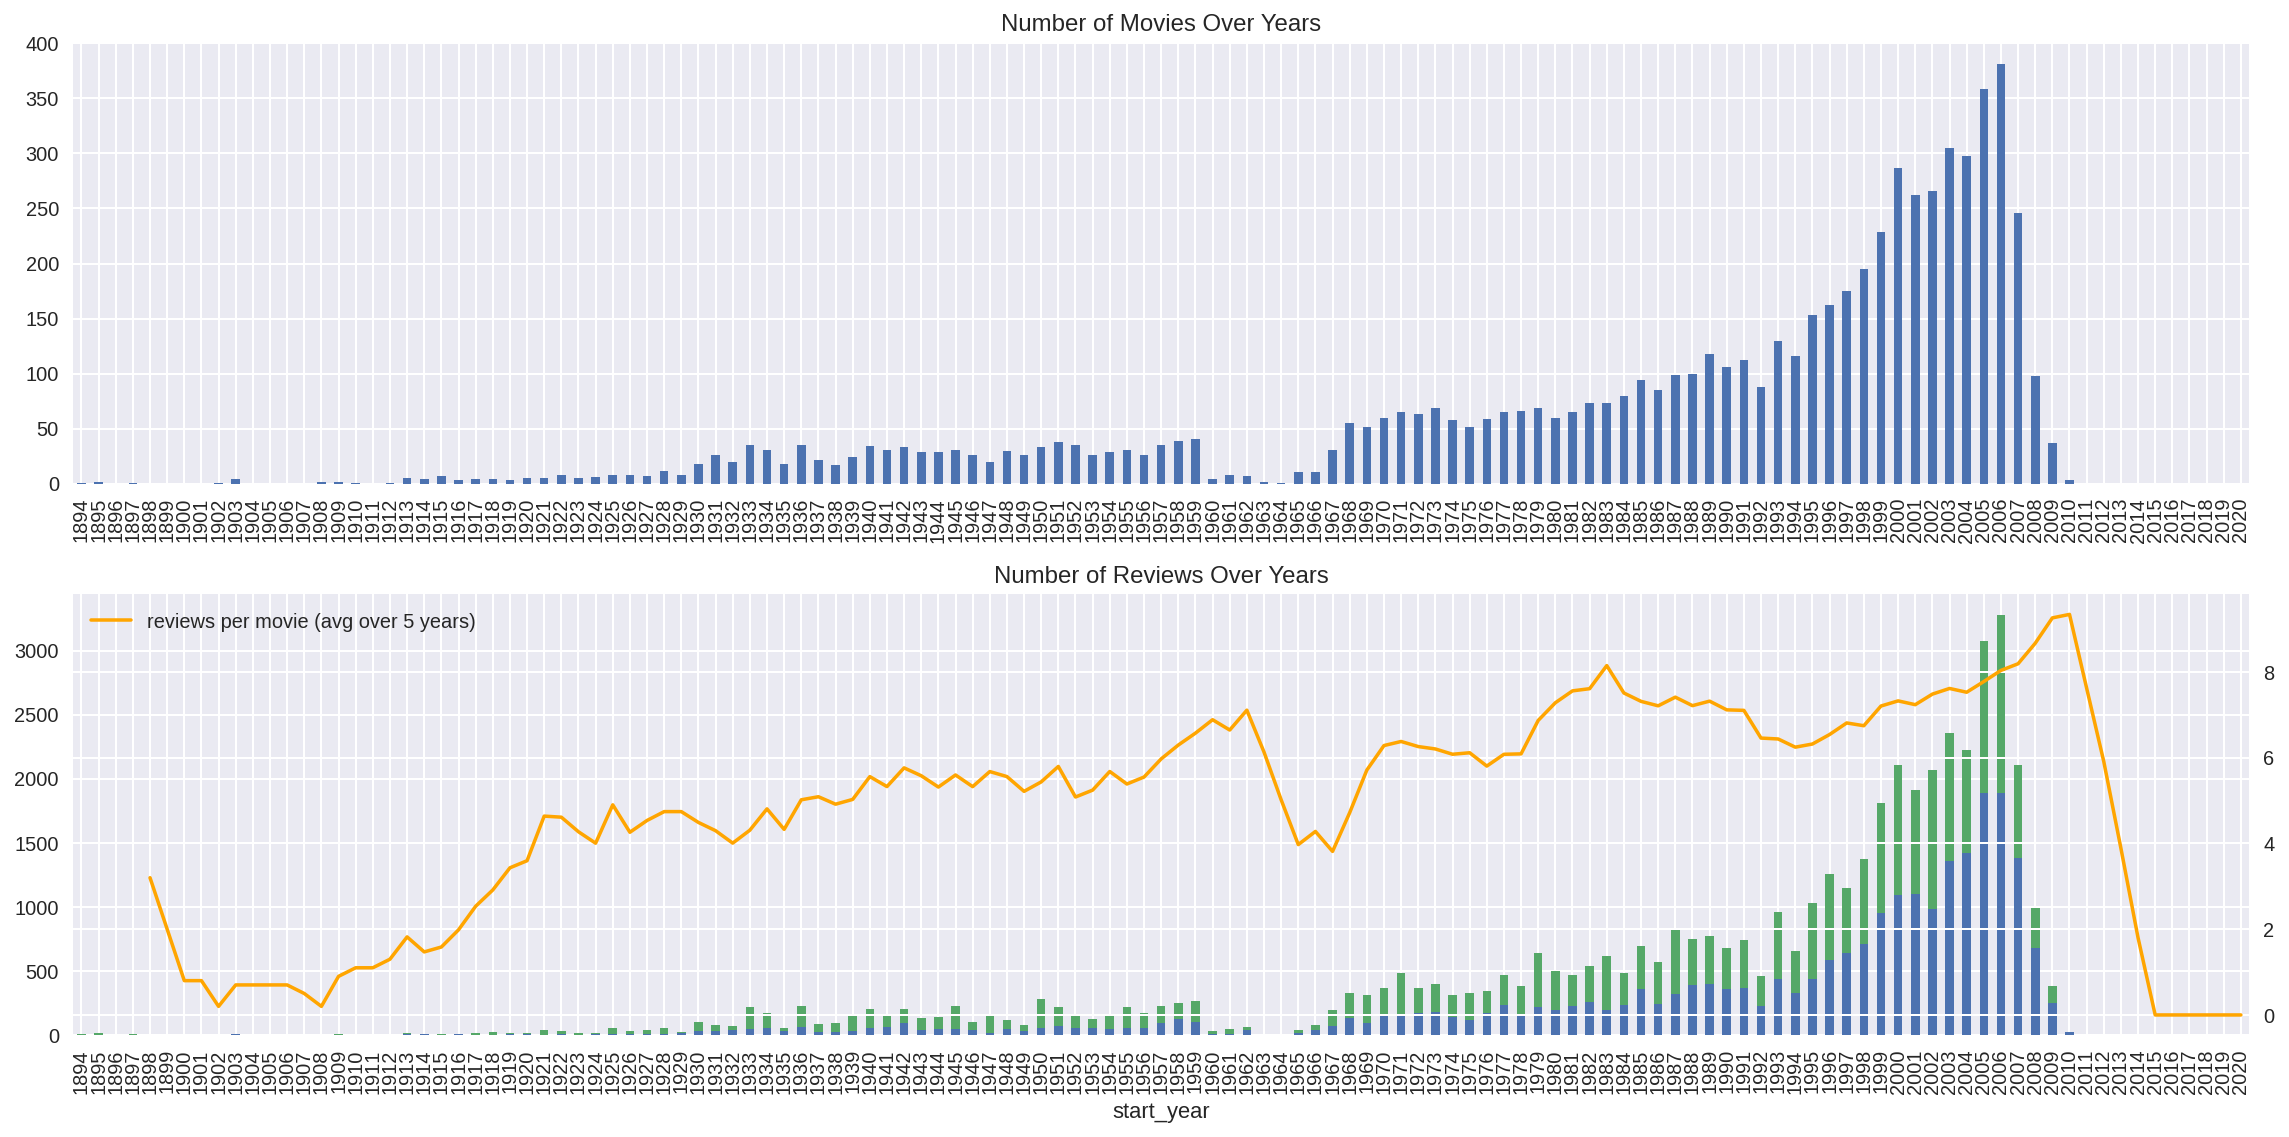

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

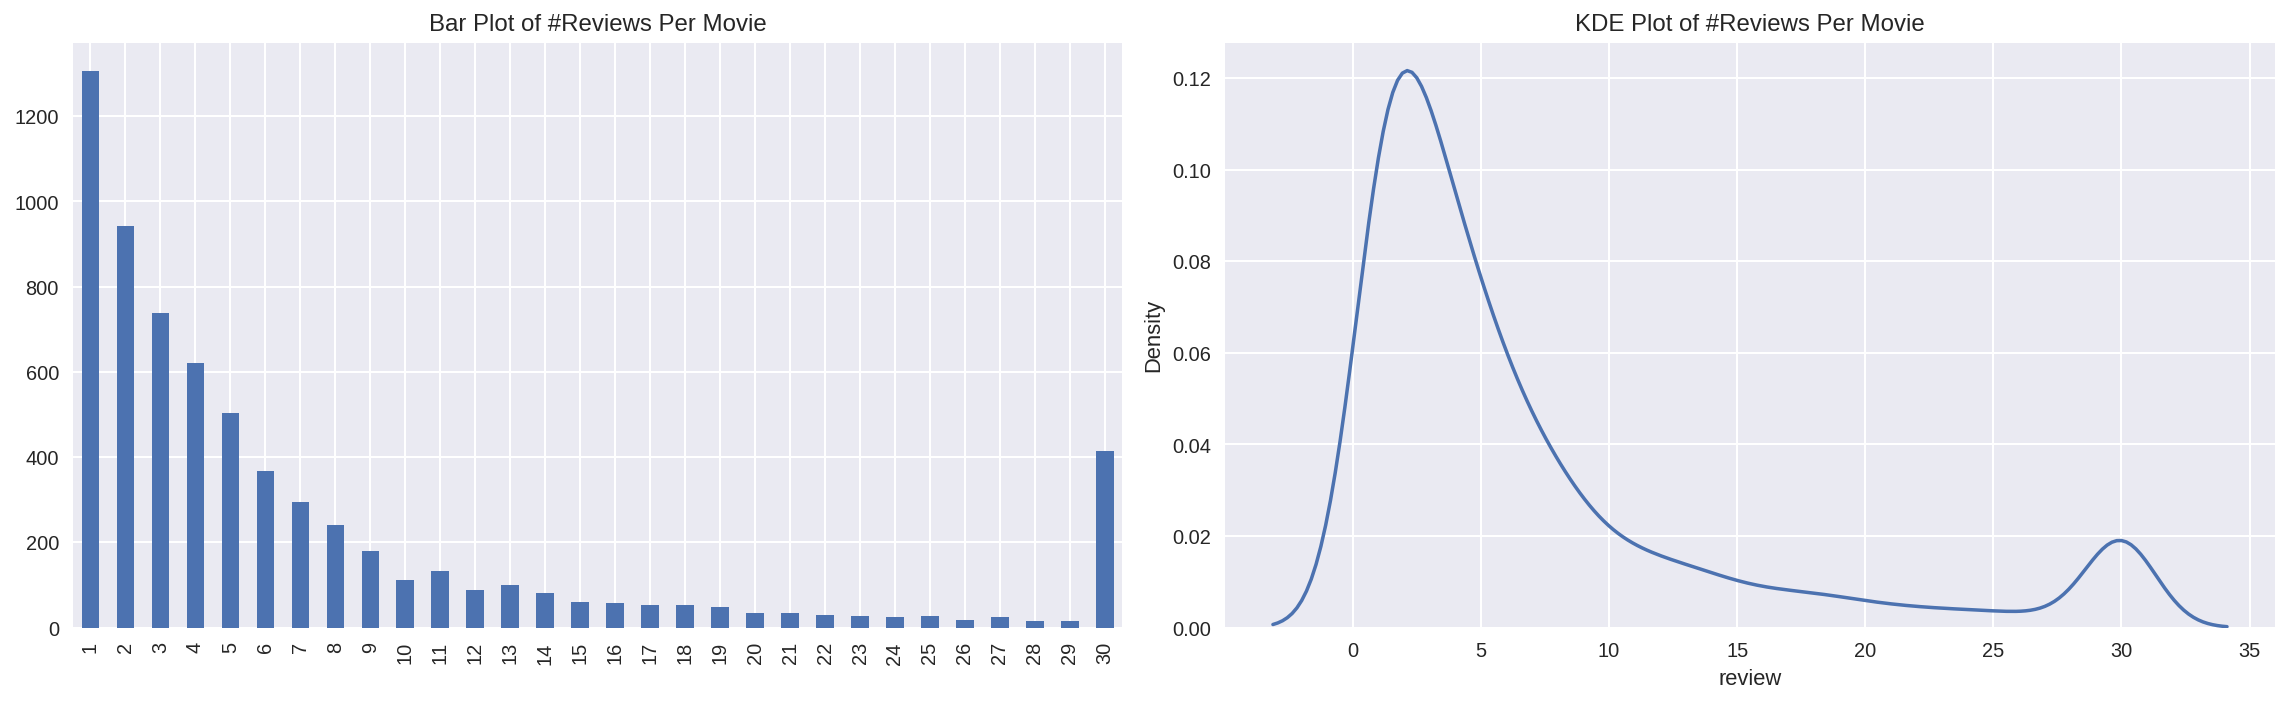

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

We see that a lot of movies with only one review. There is a decreasing trend, suggesting that as the number of reviews increase, the number of movies decrease. but we do observe a peak in movie with 30 reviews. We can plot and check for the distribution of ratings in training & test sets. 

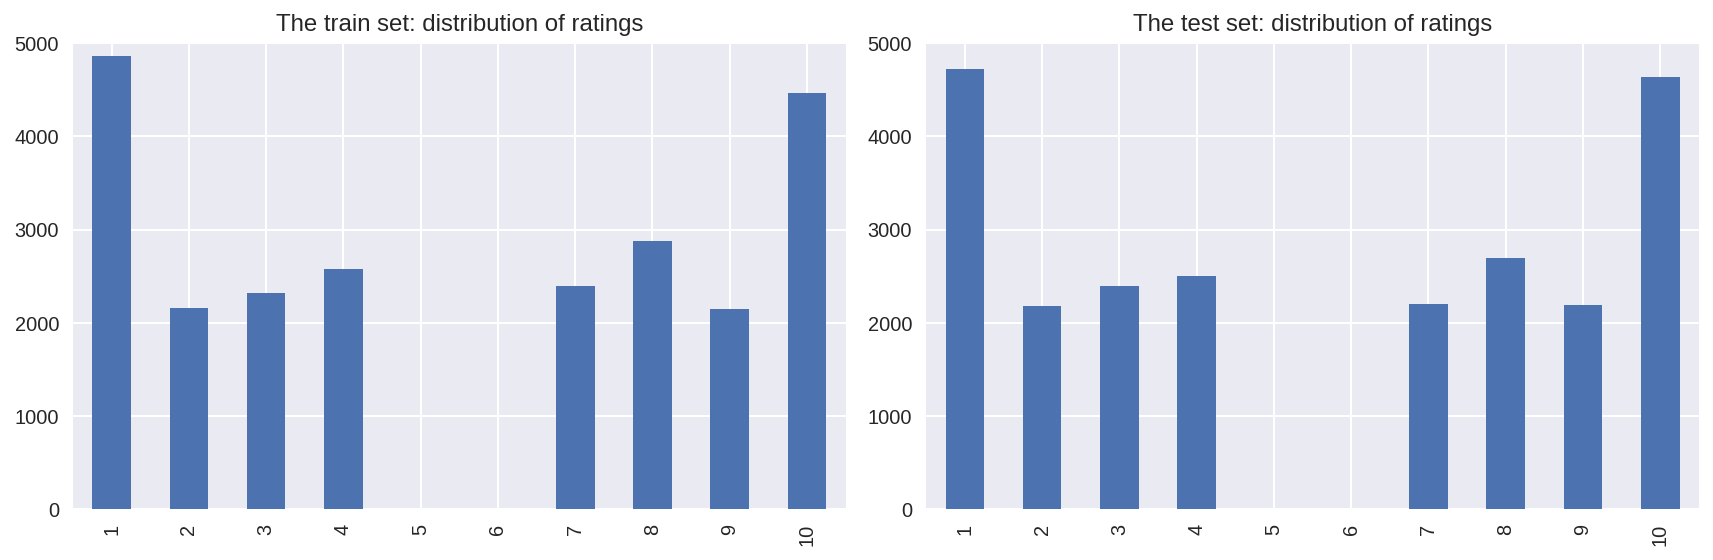

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

There are a lot of movies with 1 review and 10 reviews for both the train set and the test set. We do not see any or very less amount of movies with 5 or 6 reviews, otherwise, the number of movies are pretty similar between having 2-4 and 7-9 reviews. 

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


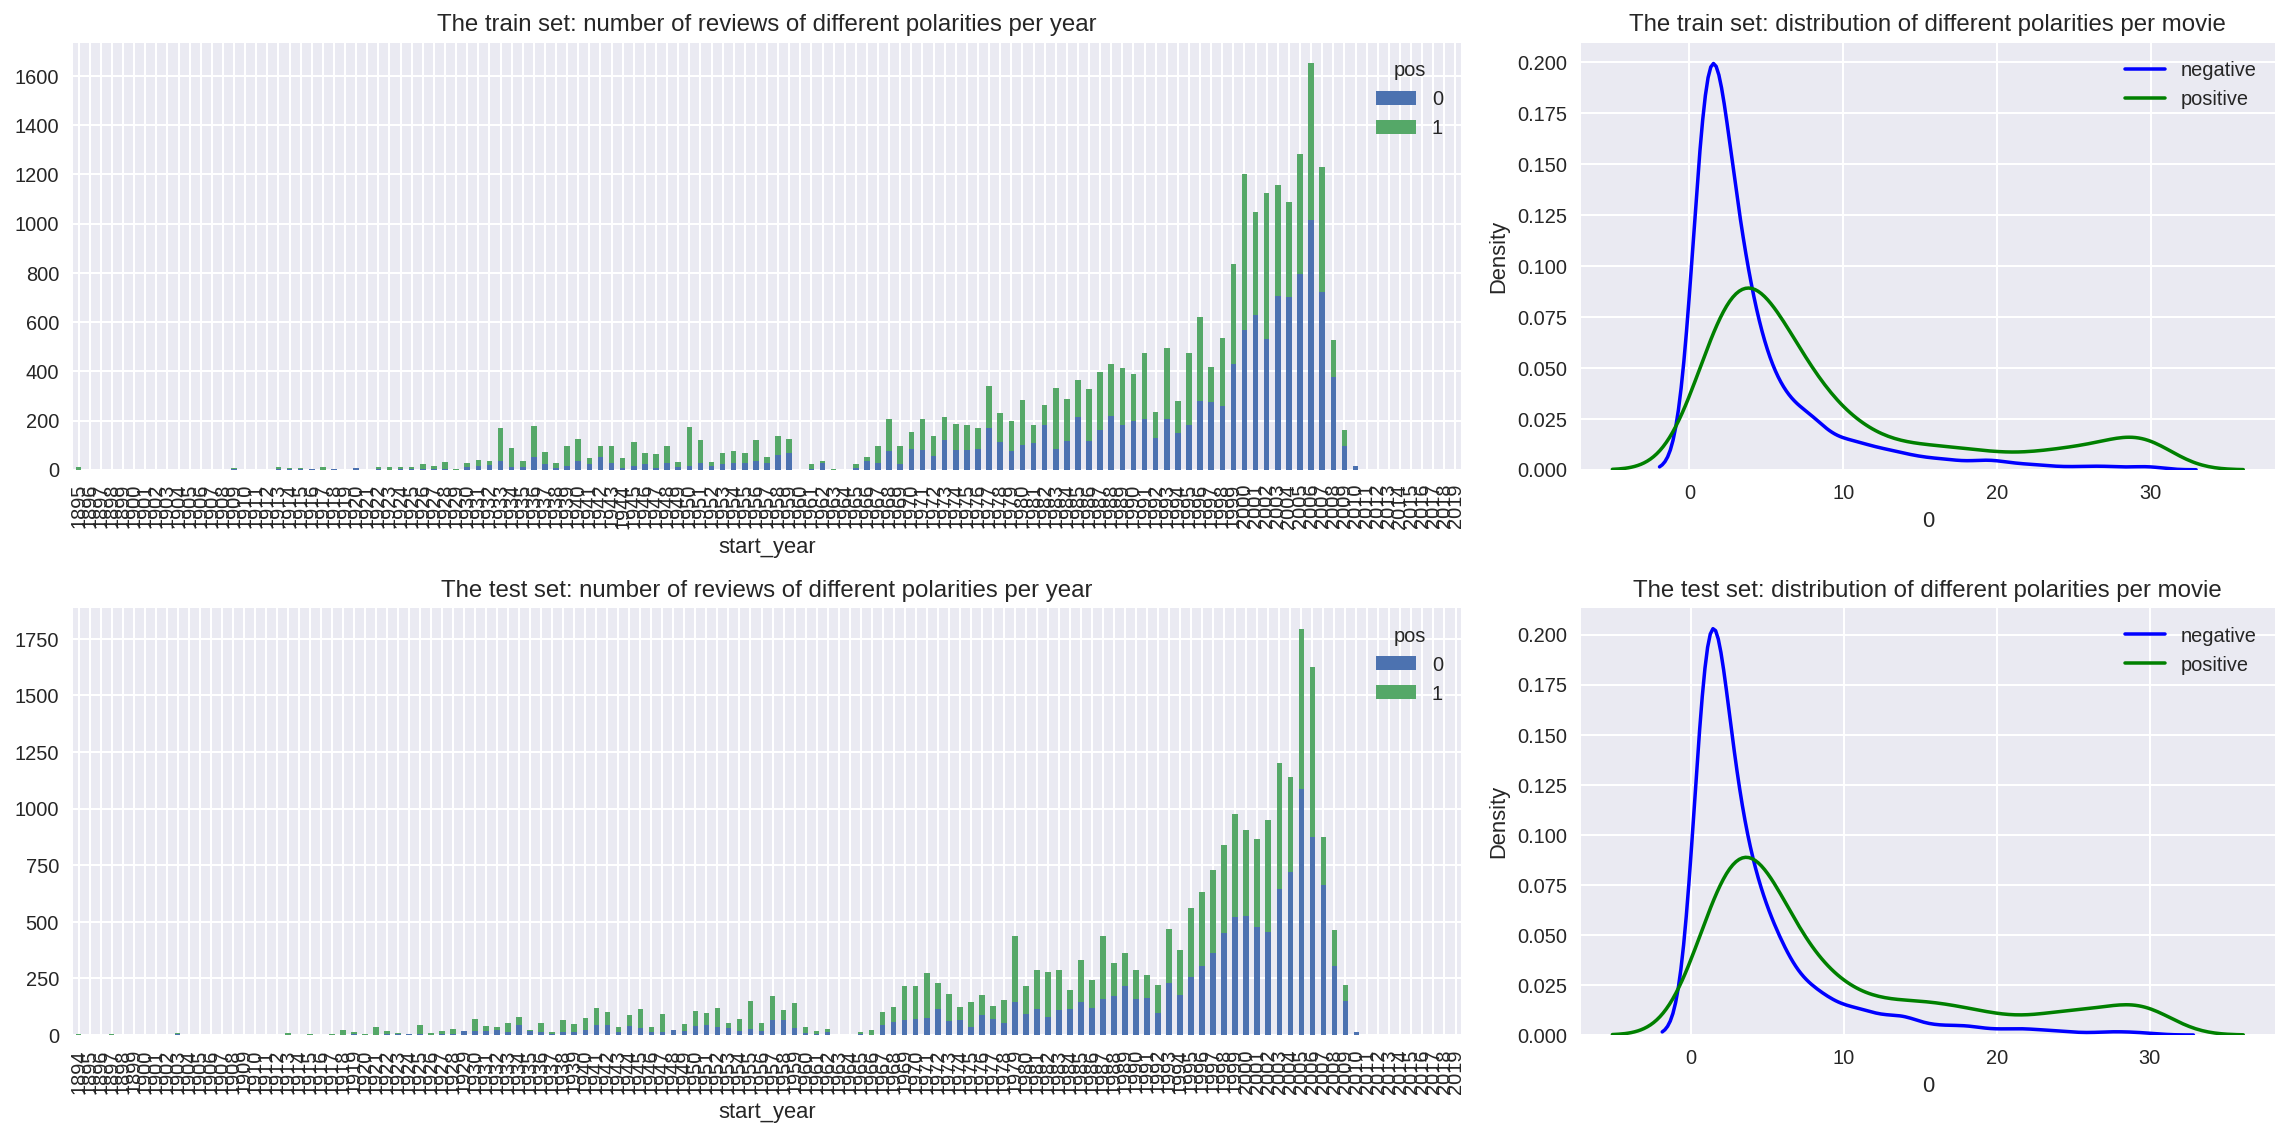

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

We see that in movies with 0-5 reviews, negative reviews outnumbered the positive reviews, but the for movies with >5 reviews, it appeared that there are more positive reviews.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
#we can create a function for this step

import re
def modify_text(text):
    processed = " ".join(re.sub(r"[^a-zA-Z']", " ", text).split())
    return processed.lower()

processed_reviews = []
for row in range(df_reviews.shape[0]):
    processed_reviews.append(modify_text(df_reviews.iloc[row]['review']))

df_reviews['review_norm'] = processed_reviews

df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 1 - Constant

In [19]:
from sklearn.dummy import DummyClassifier

In [20]:
dummy = DummyClassifier()


In [21]:
dummy.fit(df_reviews_train, train_target)
dummy.predict(df_reviews_train)

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
dummy.score(df_reviews_train, train_target)

0.5005883341738108

### Model 2 - NLTK, TF-IDF and LR

TF-IDF

In [22]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [38]:
stop_words = set(stopwords.words('english'))
count_tf_idf_2 = TfidfVectorizer(stop_words = stop_words)

corpus = df_reviews_train['review_norm']
test_corpus = df_reviews_test['review_norm']

train_features_2 = count_tf_idf_2.fit_transform(corpus)
test_features_2 = count_tf_idf_2.transform(test_corpus)

In [39]:
model_2 = LogisticRegression()
model_2.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


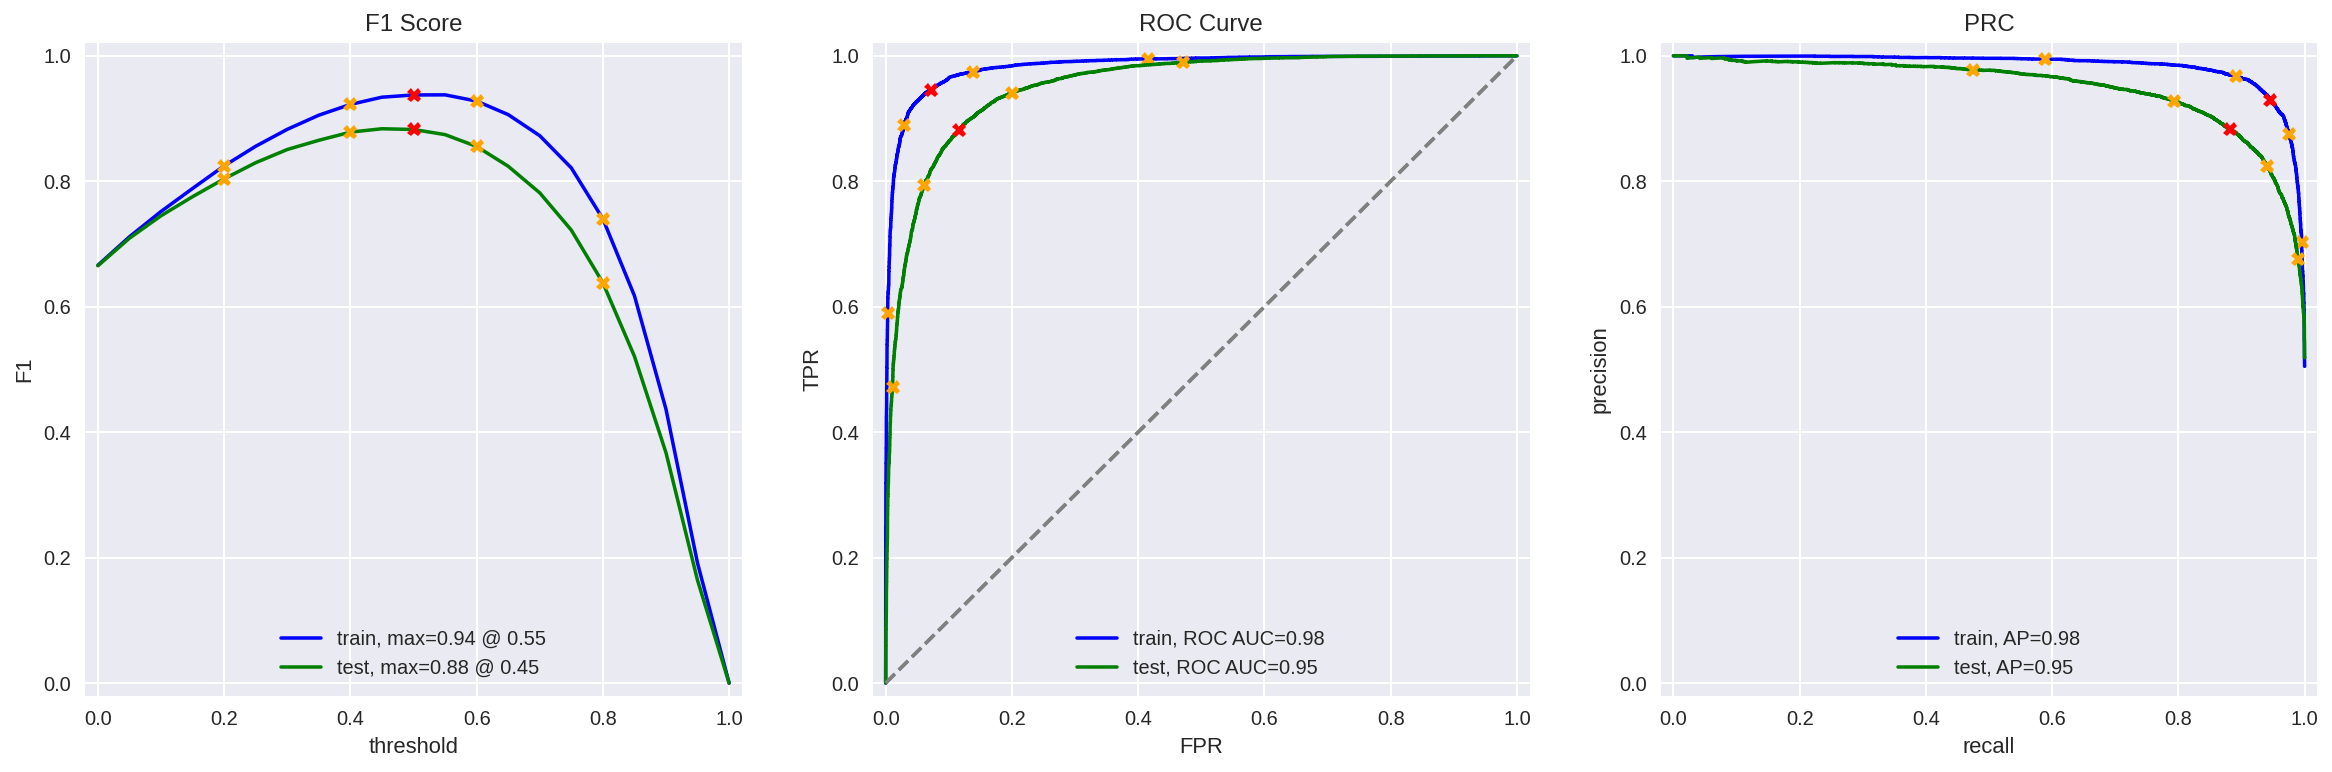

In [40]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

F1 score for this model appeared to be 0.88 for the test set. Better than the dummy classifier and above minimum requirement. 

### Model 3 - spaCy, TF-IDF and LR

In [26]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [28]:
train_3 = []
test_3 = []

for text in df_reviews_train['review_norm']:
    results = text_preprocessing_3(text)
    train_3.append(results)


for text in df_reviews_test['review_norm']:
    results = text_preprocessing_3(text)
    test_3.append(results)

In [30]:
count_tf_idf_3=TfidfVectorizer(stop_words=stopwords.words('english'))
                              
corpus = train_3
test_corpus = test_3

train_features_3 = count_tf_idf_3.fit_transform(corpus)
test_features_3 = count_tf_idf_3.transform(test_corpus)

model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


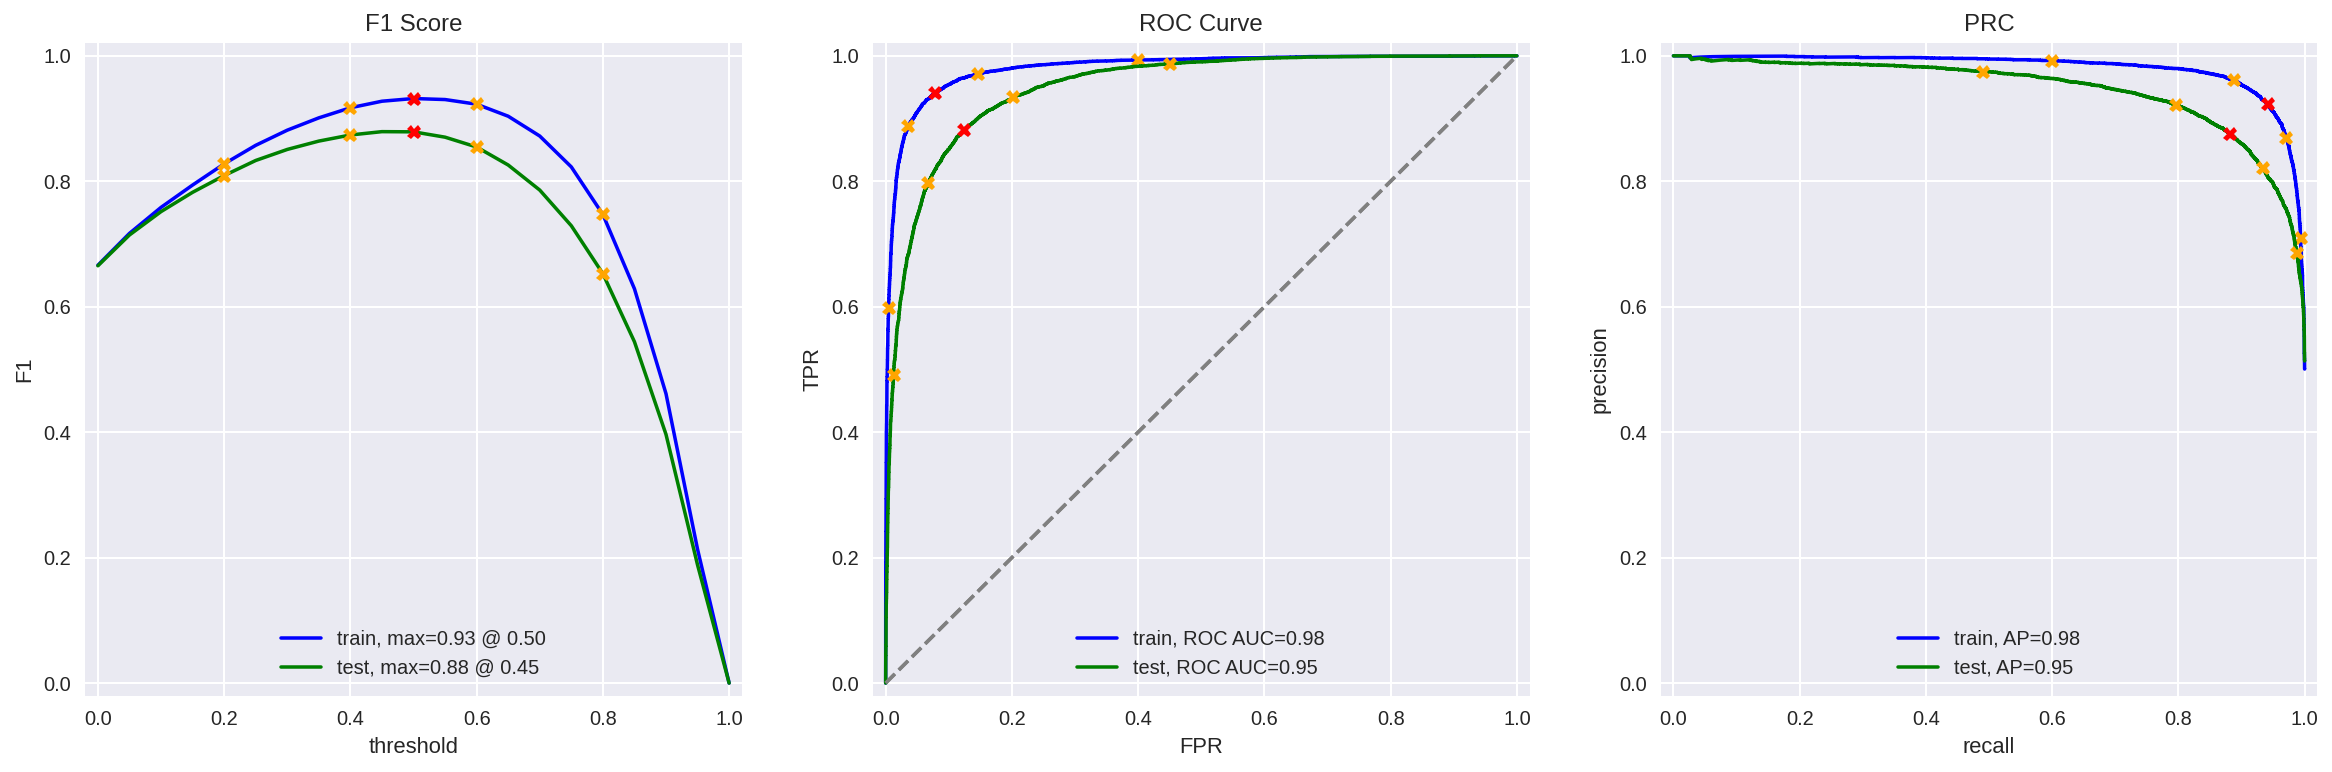

In [31]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

F1 score for this model appeared to be 0.88 for the test set. Better than the dummy classifier and above minimum requirement. But very similar to using NLTK, TF-IDF and LR. 

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [33]:
model=LGBMClassifier()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[20, 30],
            'objective':['binary'],
            'random_state':[12345]}
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(train_features_3, train_target)
best_param=grid.best_params_

In [34]:
model_4=LGBMClassifier(num_leaves=best_param['num_leaves'],
                      learning_rate=best_param['learning_rate'],
                      n_estimators=best_param['n_estimators'],
                      objective='binary',
                      random_state=12345)
model_4.fit(train_features_3, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=30, num_leaves=20,
               objective='binary', random_state=12345)

          train  test
Accuracy   0.90  0.85
F1         0.90  0.85
APS        0.96  0.93
ROC AUC    0.96  0.93


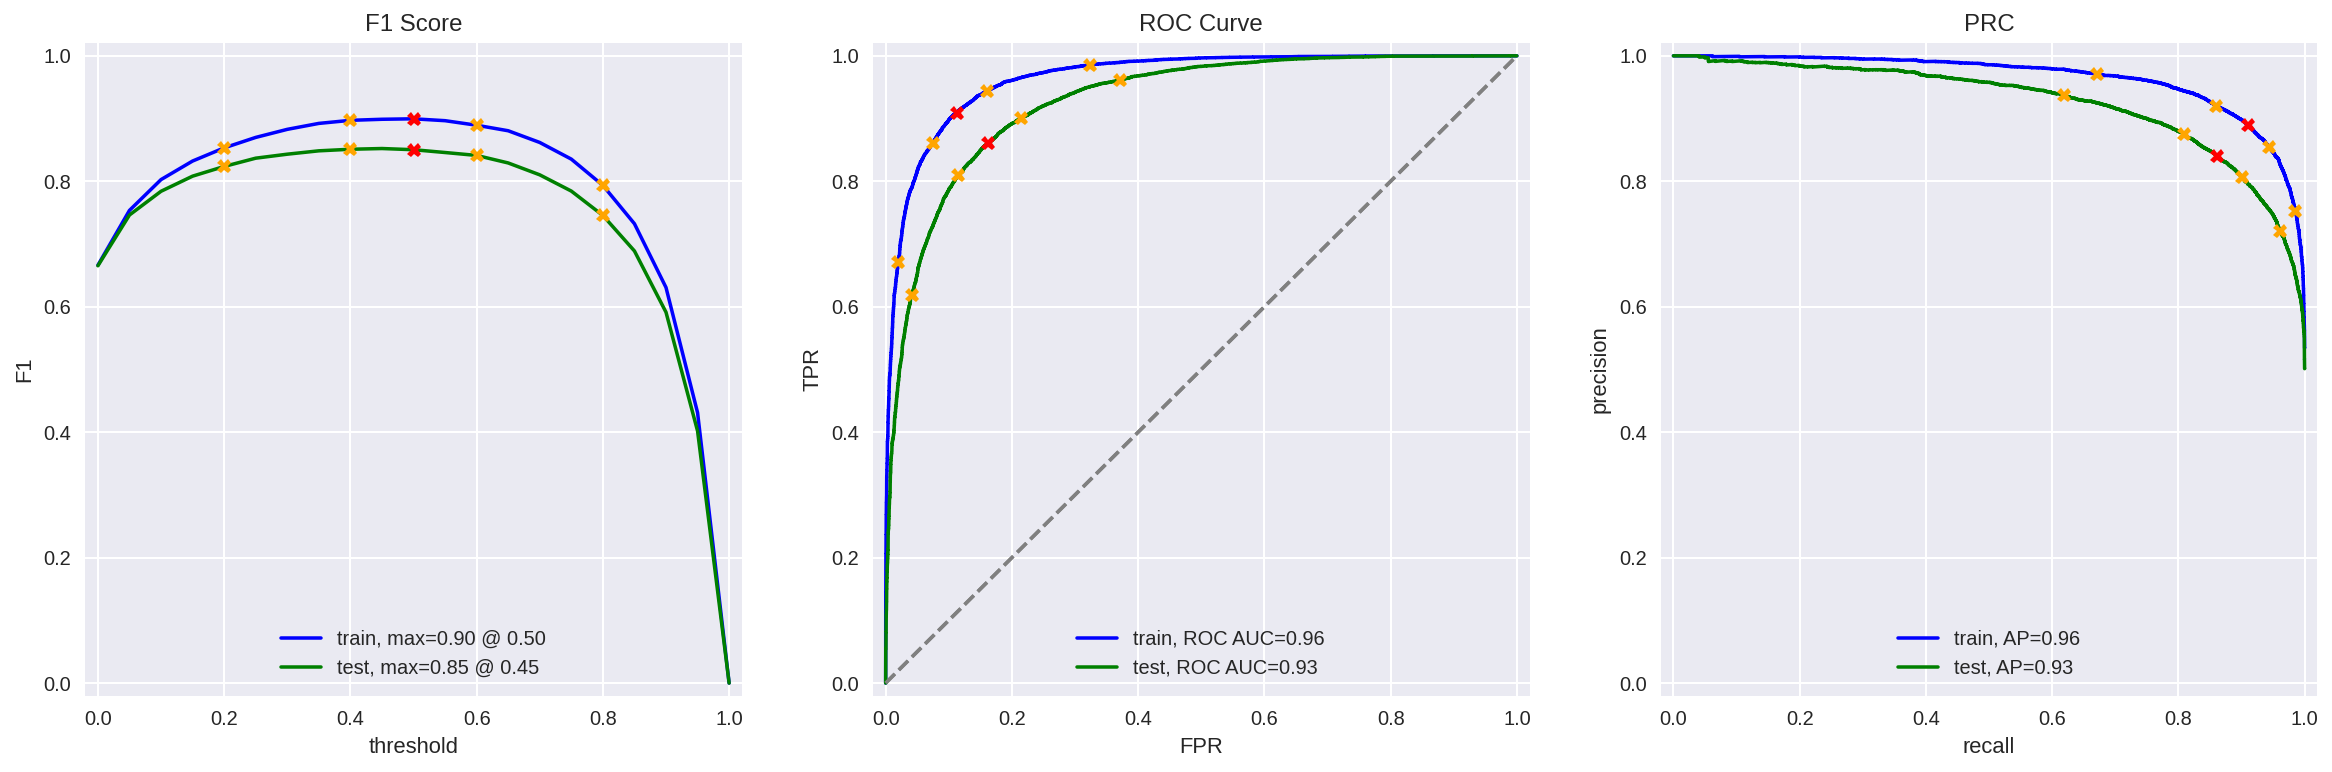

In [35]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

F1 score for this model appeared to be 0.85 for the test set with 20-30 trees. Better than the dummy classifier but did not seem to outperformed the other two models, we can tune the hyperparameters but it will take longer to run with more number of trees. 

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
for i in tqdm(range(int(8e7))):
    pass

In [ ]:
df_reviews_train_1 = df_reviews_train.copy()
df_reviews_test_1 = df_reviews_test.copy()

In [ ]:
max_sample_size = 200

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

ids_list = []
attention_mask_list = []

max_length = 512

for input_text in df_reviews_train_1.iloc[:max_sample_size]['review_norm']:
    ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
    padded = np.array(ids + [0]*(max_length - len(ids)))
    attention_mask = np.where(padded != 0, 1, 0)
    ids_list.append(padded)
    attention_mask_list.append(attention_mask)
    
batch_size = 25   

embeddings = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the {device} device.')
model.to(device)

for i in tqdm(range(len(ids_list) // batch_size)):
    
    ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        model.eval()
        batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    
    


In [ ]:
train_features_9 = np.concatenate(embeddings)
train_target = df_reviews_train_1.iloc[:max_sample_size]['pos']
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
max_sample_size = 200

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

ids_list = []
attention_mask_list = []

max_length = 512

for input_text in df_reviews_test_1.iloc[:max_sample_size]['review_norm']:
    ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
    padded = np.array(ids + [0]*(max_length - len(ids)))
    attention_mask = np.where(padded != 0, 1, 0)
    ids_list.append(padded)
    attention_mask_list.append(attention_mask)
    
batch_size = 25   

embeddings_1 = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the {device} device.')
model.to(device)

for i in tqdm(range(len(ids_list) // batch_size)):
    
    ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        model.eval()
        batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)

    embeddings_1.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    

In [ ]:
test_features_9 = np.concatenate(embeddings_1)
test_target = df_reviews_test_1.iloc[:max_sample_size]['pos']
print(test_features_9.shape)
print(test_target.shape)


In [ ]:
model_9 = LogisticRegression()
model_9.fit(train_features_9, train_target)

In [ ]:
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

it appears that our BERT model did not do so well in test set, with a F1 score of 0.75. That is likely due to a relatively small sample size. We had to take a max sample size of 200 to reduce the processing time. But for better estimation, we can increase the max sample size to the actual sample size.

## My Reviews

In [36]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples
from nltk.tokenize import word_tokenize

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didn t expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [43]:
texts = my_reviews['review_norm']


my_reviews_pred_prob = model_4.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  i did not simply like it not my kind of movie
0.30:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.39:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.48:  i didn t expect the reboot to be so good writers really cared about the source material
0.57:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.37:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 9

In [92]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

NameError: name 'BERT_text_to_embeddings' is not defined

## Conclusions

We train models to predict whether a review would be positive or negative. The model appeared to have the best F1 score was LR with NLTK and TF-IDF & LR with SpaCy and TF-IDF, with the F1 score of 0.88.  spaCy, TF-IDF and LGBMClassifier, however, did not perform so well. 
With BERT, embedding thousands of text takes a long time, so we were testing on 200 reviews. it appears that a small sample really has an effect on the resulting F1 score. We could potentially improve this by using the actually training and test set.  

However, in reviews written by ourselves and predicted with BERT, we see that it actually predicts the review with high accuracy. Only predicted one outcome wrong. 
For LR with NLTK and TF-IDF & LR with SpaCy and TF-IDF, they are more likely to predict a negative outcomes than positive. 
spaCy, TF-IDF and LGBMClassifier only got one prediction wrong, however, the probabilities are not as high, in other words, this model is more conserved in predictions.
